In [1]:
import numpy as np
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

/var/folders/ys/dnb31z655rx7znv5k0g53t5h0000gn/T/ipykernel_13115/639774668.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
# ─── 1) Load & split your data (metadata only) ────────────────────────────────
data     = np.load('threebody_dataset2.npz')
y        = data['y'][:-1].astype(int)      # shape (N-1,)
labels   = data['labels']                  # e.g. ['C','D','S']
masses   = data['masses'][:-1]            # (N-1,3)
init_pos = data['init_pos'][:-1]          # (N-1,3,2)
init_vel = data['init_vel'][:-1]          # (N-1,3,2)

# flatten metadata to (N-1,15)
meta = np.hstack([
    masses,
    init_pos.reshape(len(y), -1),
    init_vel.reshape(len(y), -1)
])

# stratified train + validation/test split (85/15)
meta_train, meta_test, y_train, y_test = train_test_split(
    meta, y,
    test_size=0.15,
    stratify=y,
    random_state=seed
)

# compute validation split fraction relative to meta_train
val_split = 0.15 / 0.85    # ≈0.1765 → yields 15% of original as validation

# scale metadata features
scaler     = StandardScaler()
meta_train = scaler.fit_transform(meta_train)
meta_test  = scaler.transform(meta_test)

n_meta, n_classes = meta_train.shape[1], len(labels)

# reshape for LSTM: (samples, timesteps=1, features=n_meta)
X_tr_seq = meta_train.reshape(-1, 1, n_meta)
X_te_seq = meta_test.reshape(-1, 1, n_meta)

In [3]:
# ─── 2) Define model-building fn for Keras-Tuner (metadata-only) ─────────────
def build_meta_model(hp):
    units1    = hp.Choice('lstm_units', [32, 64, 128])
    drop_rate = hp.Float ('dropout',      0.0, 0.5, step=0.1)
    lr        = hp.Float ('learning_rate', 1e-4, 1e-2, sampling='log')

    seq_in = Input(shape=(1, n_meta), name='meta_input')
    x = LSTM(units1, activation='tanh', name='lstm_layer')(seq_in)
    x = Dropout(drop_rate, name='dropout')(x)
    out = Dense(n_classes, activation='softmax', name='classifier')(x)

    model = Model(seq_in, out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [4]:
# ─── 3) Set up & run the tuner ───────────────────────────────────────────────
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner = kt.RandomSearch(
    build_meta_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='meta_tuner',
    project_name='threebody_meta',
    overwrite=True
)

tuner.search(
    X_tr_seq,
    y_train,
    validation_split=val_split,
    epochs=30,
    batch_size=16,
    callbacks=[es],
    verbose=2
)

Trial 15 Complete [00h 00m 02s]
val_accuracy: 0.9555555582046509

Best val_accuracy So Far: 0.9555555582046509
Total elapsed time: 00h 00m 23s


In [5]:
# ─── 4) Build & retrain best model on full training+validation data ─────────
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_tr_seq,
    y_train,
    validation_split=val_split,
    epochs=50,
    batch_size=16,
    callbacks=[es],
    verbose=2
)

Epoch 1/50
14/14 - 1s - loss: 0.9870 - accuracy: 0.6476 - val_loss: 0.8369 - val_accuracy: 0.7556 - 714ms/epoch - 51ms/step
Epoch 2/50
14/14 - 0s - loss: 0.7251 - accuracy: 0.8333 - val_loss: 0.6201 - val_accuracy: 0.8222 - 20ms/epoch - 1ms/step
Epoch 3/50
14/14 - 0s - loss: 0.5241 - accuracy: 0.8381 - val_loss: 0.4924 - val_accuracy: 0.8000 - 18ms/epoch - 1ms/step
Epoch 4/50
14/14 - 0s - loss: 0.4068 - accuracy: 0.8476 - val_loss: 0.4180 - val_accuracy: 0.8222 - 18ms/epoch - 1ms/step
Epoch 5/50
14/14 - 0s - loss: 0.3390 - accuracy: 0.8619 - val_loss: 0.3650 - val_accuracy: 0.8222 - 18ms/epoch - 1ms/step
Epoch 6/50
14/14 - 0s - loss: 0.2857 - accuracy: 0.8762 - val_loss: 0.3125 - val_accuracy: 0.8444 - 18ms/epoch - 1ms/step
Epoch 7/50
14/14 - 0s - loss: 0.2548 - accuracy: 0.9095 - val_loss: 0.2837 - val_accuracy: 0.8444 - 17ms/epoch - 1ms/step
Epoch 8/50
14/14 - 0s - loss: 0.2292 - accuracy: 0.9333 - val_loss: 0.2673 - val_accuracy: 0.8444 - 16ms/epoch - 1ms/step
Epoch 9/50
14/14 - 0s 

In [6]:
# ─── 5) Evaluate on the test set ─────────────────────────────────────────────
test_loss, test_acc = best_model.evaluate(X_te_seq, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.2%}\n")

y_pred_probs = best_model.predict(X_te_seq)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, target_names=labels))


Test Accuracy: 93.33%

2/2 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           C       1.00      0.80      0.89        15
           D       0.94      1.00      0.97        15
           S       0.88      1.00      0.94        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



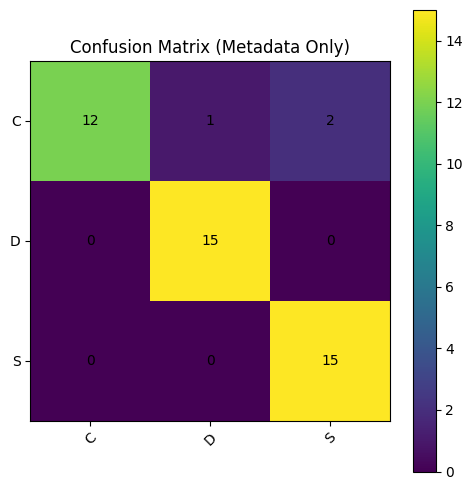

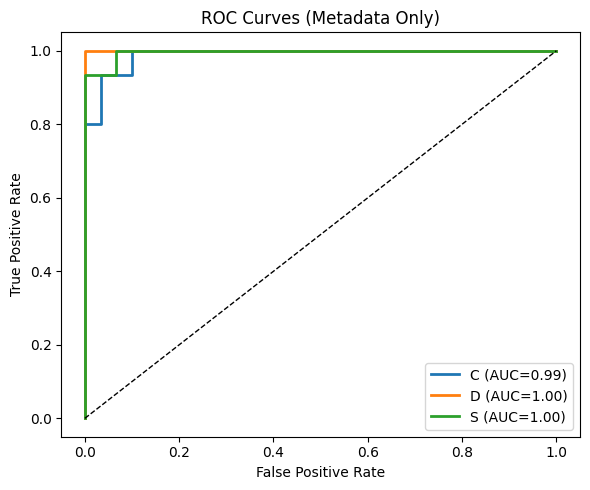

2/2 [==============================] - 0s 1ms/step


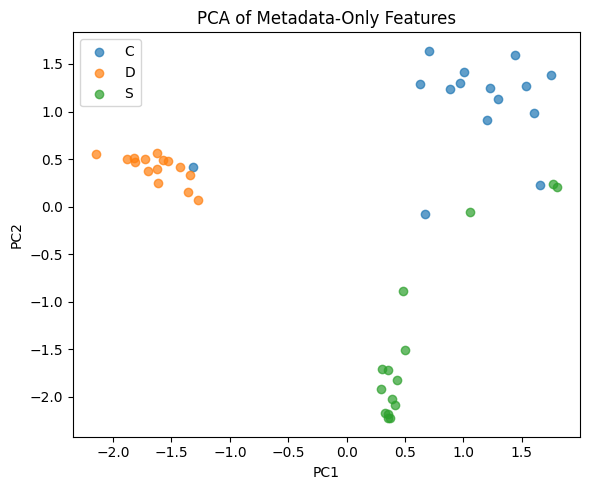

In [7]:
# ─── 6) Analysis plots ─────────────────────────────────────────────────────────
# 6a) Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.title("Confusion Matrix (Metadata Only)")
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
plt.xticks(range(n_classes), labels, rotation=45)
plt.yticks(range(n_classes), labels)
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

# 6b) ROC curves (one-vs-rest)
plt.figure(figsize=(6,5))
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
for i, lab in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{lab} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Metadata Only)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 6c) PCA scatter of learned features (LSTM layer)
feat_extractor = Model(
    inputs=best_model.input,
    outputs=best_model.get_layer('lstm_layer').output
)
states = feat_extractor.predict(X_te_seq)
pca = PCA(n_components=2, random_state=seed)
pcs = pca.fit_transform(states)
plt.figure(figsize=(6,5))
for idx, lab in enumerate(labels):
    mask = (y_test == idx)
    plt.scatter(pcs[mask,0], pcs[mask,1], alpha=0.7, label=lab)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Metadata-Only Features")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd

# Collect ROC data
roc_data = []
for i, lab in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc     = auc(fpr, tpr)
    for f, t in zip(fpr, tpr):
        roc_data.append({
            "model": "LSTM",  # Change to "GRU" or "LSTM" in respective scripts
            "class": lab,
            "fpr": f,
            "tpr": t,
            "auc": roc_auc
        })

# Save to CSV
df_roc = pd.DataFrame(roc_data)
df_roc.to_csv("roc_data_lstm.csv", index=False)  # Use different file names per model